# 1. LPM-модель (Linear Probability Model): подгонка, коэффициенты, t‑тест

## Что это такое?
Это обычная линейная регрессия, но где зависимая переменная — 0 или 1 (например, поступил в университет или нет).

### Как решать?
Оцениваем коэффициенты как в обычной линейной регрессии.
Получаем: β₀, β₁ и стандартные ошибки.
Считаем t‑статистику: показывает, значим ли коэффициент.

Модель может предсказывать вероятность больше 1 или меньше 0 → это плохо.
Стандартные ошибки могут быть неправильные (лучше использовать робастные ошибки).

In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_params
from scipy.stats import t # t-распределение

### Тестируем гипотезу, t-test
$$H_0:\\beta=0$$

Тестовая статистика $$t=\\frac{\\hat{\\beta}}{s.e.(\\beta)}$$

Критическое $$t_{cr}=t_{df=n-k-1}(\\alpha)$$
Гипотеза отвергается если $|t|>t_{cr}$ или $P<\\alpha$

In [3]:
# подключим датасет loanapp по ссылке 
loanapp_df = pd.read_csv('loanapp.csv', na_values=(' ', '', '  '))
loanapp_df.shape

(1989, 59)

In [4]:
#зададим спецификацию модели через формулу
mod_lpm = smf.ols(formula='approve~mortno+unem+dep+male+married+yjob+self', data=loanapp_df)

In [5]:
# подгонка модели с поправкой на гетероскедастичность
res_lpm_hc = mod_lpm.fit(cov_type='HC3')
print(res_lpm_hc.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
No. Observations:                1971   F-statistic:                     5.849
Covariance Type:                  HC3   Prob (F-statistic):           9.77e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8642      0.023     37.135      0.000       0.819       0.910
mortno         0.0733      0.015      4.886      0.000       0.044       0.103
unem          -0.0064      0.004     -1.605      0.108      -0.014       0.001
dep           -0.0185      0.008     -2.429      0.015      -0.033      -0.004
male           0.0019      0.021      0.089      0.929      -0.040       0.044
married        0.0459      0.019      2.458      0.0

#### тестируем гипотезу на уровне значимости 1%

In [6]:
# робастные t-статистики для каждого коэффициента с округлением до 3-х десятичных знаков
res_lpm_hc.tvalues.round(3) 
# Робастные стандартные ошибки — это «умные» ошибки, которые учитывают гетероскедастичность

Intercept    37.135
mortno        4.886
unem         -1.605
dep          -2.429
male          0.089
married       2.458
yjob         -0.107
self         -1.464
dtype: float64

In [7]:

# Результаты t-теста для коэффициентов (робастные s.e.)
summary_params(res_lpm_hc, alpha=0.01)

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995]
Intercept,0.864212,0.023272,37.134809,7.710753e-302,0.804266,0.924157
mortno,0.073251,0.014993,4.885535,1.031484e-06,0.034630,0.111872
unem,-0.006434,0.004008,-1.605254,1.084379e-01,-0.016758,0.003890
dep,-0.018472,0.007605,-2.429081,1.513714e-02,-0.038061,0.001116
male,0.001907,0.021351,0.089319,9.288281e-01,-0.053089,0.056903
married,0.045946,0.018692,2.458098,1.396750e-02,-0.002201,0.094093
yjob,-0.000662,0.006189,-0.107050,9.147495e-01,-0.016603,0.015278
self,-0.036120,0.024671,-1.464087,1.431703e-01,-0.099667,0.027427


### Вычислите критическое значения для t-теста. Ответ округлите до 3-х десятичных знаков.

In [10]:

# 1%-критическое значение t-распределения
t_cr = np.round(t.ppf(q=1-0.01/2, df=res_lpm_hc.df_resid), 3)
t_cr

2.578

In [13]:
# проверим значимость коэффициентов используя t_cr
df_hc = np.round(summary_params(res_lpm_hc, alpha=0.01), 3)
df_hc['significance'] = df_hc.apply(lambda x: 'Значим' if np.abs(x['t'])>t_cr else 'Незначим', axis=1)
df_hc
# по сути, если наше t по модулю будет больше t_cr, то коэф значимый, в нашем случае значимый только mortno

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995],significance
Intercept,0.864,0.023,37.135,0.000,0.804,0.924,Значим
mortno,0.073,0.015,4.886,0.000,0.035,0.112,Значим
unem,-0.006,0.004,-1.605,0.108,-0.017,0.004,Незначим
dep,-0.018,0.008,-2.429,0.015,-0.038,0.001,Незначим
male,0.002,0.021,0.089,0.929,-0.053,0.057,Незначим
married,0.046,0.019,2.458,0.014,-0.002,0.094,Незначим
yjob,-0.001,0.006,-0.107,0.915,-0.017,0.015,Незначим
self,-0.036,0.025,-1.464,0.143,-0.100,0.027,Незначим


In [14]:
# проверим значимость коэффициентов используя P-value
df_hc = np.round(summary_params(res_lpm_hc, alpha=0.01), 3)
df_hc['significance'] = df_hc.apply(lambda x: 'Значим' if x['P>|t|']<0.01 else 'Незначим', axis=1)
df_hc
# смотрим на столбец P> |t|, и если там меньше уровня значимости (у нас 0,01), то коэф значим

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995],significance
Intercept,0.864,0.023,37.135,0.000,0.804,0.924,Значим
mortno,0.073,0.015,4.886,0.000,0.035,0.112,Значим
unem,-0.006,0.004,-1.605,0.108,-0.017,0.004,Незначим
dep,-0.018,0.008,-2.429,0.015,-0.038,0.001,Незначим
male,0.002,0.021,0.089,0.929,-0.053,0.057,Незначим
married,0.046,0.019,2.458,0.014,-0.002,0.094,Незначим
yjob,-0.001,0.006,-0.107,0.915,-0.017,0.015,Незначим
self,-0.036,0.025,-1.464,0.143,-0.100,0.027,Незначим


#### Вывод: значим mortno

## Укажите результаты неробастного t-тест:

Результаты t-теста для коэффициентов (неробастные s.e.)

In [15]:
# подгонка модели
res_lpm_ols = mod_lpm.fit(cov_type='nonrobust')

In [16]:
# Результаты t-теста для коэффициентов (неробастные s.e.)
summary_params(res_lpm_ols, alpha=0.01)

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995]
Intercept,0.864212,0.021910,39.444211,4.383373e-251,0.807721,0.920702
mortno,0.073251,0.016000,4.578293,4.981615e-06,0.031999,0.114503
unem,-0.006434,0.003463,-1.857970,6.332293e-02,-0.015363,0.002495
dep,-0.018472,0.007187,-2.570198,1.023721e-02,-0.037003,0.000058
male,0.001907,0.020314,0.093879,9.252152e-01,-0.050469,0.054283
married,0.045946,0.017644,2.604031,9.282926e-03,0.000453,0.091439
yjob,-0.000662,0.006686,-0.099092,9.210751e-01,-0.017900,0.016575
self,-0.036120,0.022289,-1.620504,1.052847e-01,-0.093589,0.021349


In [18]:
# проверим значимость коэффициентов используя P-value
df_ols = np.round(summary_params(res_lpm_ols, alpha=0.01), 3)
df_ols['significance'] = df_ols.apply(lambda x: 'Значим' if x['P>|t|']<0.01 else 'Незначим', axis=1)
df_ols
#здесь уже получается так, что значимы несколько коэффициентовь (P меньше 0,01 у нескольких)

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995],significance
Intercept,0.864,0.022,39.444,0.000,0.808,0.921,Значим
mortno,0.073,0.016,4.578,0.000,0.032,0.115,Значим
unem,-0.006,0.003,-1.858,0.063,-0.015,0.002,Незначим
dep,-0.018,0.007,-2.570,0.010,-0.037,0.000,Незначим
male,0.002,0.020,0.094,0.925,-0.050,0.054,Незначим
married,0.046,0.018,2.604,0.009,0.000,0.091,Значим
yjob,-0.001,0.007,-0.099,0.921,-0.018,0.017,Незначим
self,-0.036,0.022,-1.621,0.105,-0.094,0.021,Незначим


In [19]:
# проверим значимость коэффициентов используя t_cr
df_ols = np.round(summary_params(res_lpm_ols, alpha=0.01), 3)
df_ols['significance'] = df_ols.apply(lambda x: 'Значим' if np.abs(x['t'])>t_cr else 'Незначим', axis=1)
df_ols

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995],significance
Intercept,0.864,0.022,39.444,0.000,0.808,0.921,Значим
mortno,0.073,0.016,4.578,0.000,0.032,0.115,Значим
unem,-0.006,0.003,-1.858,0.063,-0.015,0.002,Незначим
dep,-0.018,0.007,-2.570,0.010,-0.037,0.000,Незначим
male,0.002,0.020,0.094,0.925,-0.050,0.054,Незначим
married,0.046,0.018,2.604,0.009,0.000,0.091,Значим
yjob,-0.001,0.007,-0.099,0.921,-0.018,0.017,Незначим
self,-0.036,0.022,-1.621,0.105,-0.094,0.021,Незначим



ВЫВОД: На уровне значимости 1% значимы коэффициенты: mortno и married

Но!! Обычный t‑тест становится ненадежным когда он неробастный:
Стандартные ошибки считаются неправильно
t‑статистика получается неправильной
Ты можешь ошибочно решить, что переменная важна (или наоборот)

### Значимость выбранных коэффициентов

Тестируем значимость $\\beta_{mortno}$ и $\\beta_{male}$

In [21]:
# робастный t-тест
res_lpm_hc.t_test('mortno=0, male=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0733      0.015      4.886      0.000       0.044       0.103
c1             0.0019      0.021      0.089      0.929      -0.040       0.044

## Пример задачи

Для датасета loanapp рассмотрим регрессию approve на appinc, appinc^2, mortno, unem, dep, male, married, yjob, self

Подгоните модель и вычислите (робастные) t-статистика для каждого коэффициента. Ответ округлите до 3-х десятичных знаков.

In [49]:
#зададим спецификацию модели через формулу
mod_2 = smf.ols(formula='approve~appinc+I(appinc**2)+mortno+unem+dep+male+married+yjob+self', data=loanapp_df)

In [50]:
# подгонка модели с поправкой на гетероскедастичность
res_lpm_hc2 = mod_2.fit(cov_type='HC3')
print(res_lpm_hc2.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.021
No. Observations:                1971   F-statistic:                     5.032
Covariance Type:                  HC3   Prob (F-statistic):           9.81e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8420      0.027     31.003      0.000       0.789       0.895
appinc             0.0005      0.000      1.958      0.050   -4.48e-07       0.001
I(appinc ** 2) -1.007e-06   4.24e-07     -2.374      0.018   -1.84e-06   -1.76e-07
mortno             0.0660      0.015      4.321      0.000       0.036       0.096
unem              -0.0061      0.004     -1.515      0.130      -0.014       0.002
dep               -0.017

In [51]:
# Результаты t-теста для коэффициентов (робастные s.e.)
summary_params(res_lpm_hc2, alpha=0.01)

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995]
Intercept,0.841997,2.715820e-02,31.003423,4.847279e-211,0.772042,9.119521e-01
appinc,0.000513,2.618182e-04,1.958252,5.020042e-02,-0.000162,1.187105e-03
I(appinc ** 2),-0.000001,4.242271e-07,-2.374148,1.758948e-02,-0.000002,8.555847e-08
mortno,0.066040,1.528194e-02,4.321410,1.550354e-05,0.026676,1.054032e-01
unem,-0.006103,4.029059e-03,-1.514857,1.298086e-01,-0.016482,4.274720e-03
dep,-0.017071,7.486540e-03,-2.280204,2.259559e-02,-0.036355,2.213210e-03
male,-0.002890,2.140476e-02,-0.135016,8.925990e-01,-0.058025,5.224501e-02
married,0.043276,1.874304e-02,2.308933,2.094732e-02,-0.005002,9.155528e-02
yjob,-0.000877,6.262274e-03,-0.140110,8.885728e-01,-0.017008,1.525314e-02
self,-0.040432,2.524373e-02,-1.601646,1.092340e-01,-0.105455,2.459203e-02


In [52]:
# робастные t-статистики для каждого коэффициента с округлением до 3-х десятичных знаков
res_lpm_hc2.tvalues.round(3) 

Intercept         31.003
appinc             1.958
I(appinc ** 2)    -2.374
mortno             4.321
unem              -1.515
dep               -2.280
male              -0.135
married            2.309
yjob              -0.140
self              -1.602
dtype: float64

In [53]:

# 1%-критическое значение t-распределения
t_cr = np.round(t.ppf(q=1-0.01/2, df=res_lpm_hc2.df_resid), 3)
t_cr

2.578

In [54]:
# проверим значимость коэффициентов используя t_cr
df_hc = np.round(summary_params(res_lpm_hc2, alpha=0.01), 3)
df_hc['significance'] = df_hc.apply(lambda x: 'Значим' if np.abs(x['t'])>t_cr else 'Незначим', axis=1)
df_hc

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995],significance
Intercept,0.842,0.027,31.003,0.000,0.772,0.912,Значим
appinc,0.001,0.000,1.958,0.050,-0.000,0.001,Незначим
I(appinc ** 2),-0.000,0.000,-2.374,0.018,-0.000,0.000,Незначим
mortno,0.066,0.015,4.321,0.000,0.027,0.105,Значим
unem,-0.006,0.004,-1.515,0.130,-0.016,0.004,Незначим
dep,-0.017,0.007,-2.280,0.023,-0.036,0.002,Незначим
male,-0.003,0.021,-0.135,0.893,-0.058,0.052,Незначим
married,0.043,0.019,2.309,0.021,-0.005,0.092,Незначим
yjob,-0.001,0.006,-0.140,0.889,-0.017,0.015,Незначим
self,-0.040,0.025,-1.602,0.109,-0.105,0.025,Незначим


Ответ: значим mortno

In [ ]:
# 1. LPM-модель (Linear Probability Model): подгонка, коэффициенты, t‑тест

# LPM-модель: F-тест, прогнозирование и интерпретация прогноза

## F‑тест отвечает на вопрос:
🧠 «Влияют ли все переменные вместе на y?»

F‑тест проверяет гипотезу:
H₀: все коэффициенты (кроме константы) равны 0 → модель бесполезна
H₁: хотя бы один ≠ 0 → модель даёт полезную информацию

# F-тест: значимость регрессии\n",
Тестируется гипотеза $H_0:\\beta_1=\\cdots=\\beta_k=0$\
Тестовая статистика $F$ (расчитывается автоматически)
Критическое значение $F_{cr}=F_{df1=k, df2=n-k-1}(\\alpha)$

Гипотеза отвергается, если $F>F_{cr}$ или $P<\\alpha$

если отклоняем гипотезу H0 значит модель значима!!

In [58]:
from statsmodels.iolib.summary2 import summary_col, summary_params # вывод результатов тестирования
from scipy.stats import f 

In [59]:
#зададим спецификацию модели через формулу
mod_lpm_f = smf.ols(formula='approve~unem+male+yjob+self', data=loanapp_df)

In [60]:
# подгонка модели с поправкой на гетероскедастичность
res_lpm_hc_f = mod_lpm_f.fit(cov_type='HC3')
print(res_lpm_hc_f.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
No. Observations:                1974   F-statistic:                     1.677
Covariance Type:                  HC3   Prob (F-statistic):              0.153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8914      0.023     39.586      0.000       0.847       0.936
unem          -0.0074      0.004     -1.838      0.066      -0.015       0.000
male           0.0209      0.020      1.056      0.291      -0.018       0.060
yjob           0.0013      0.006      0.210      0.834      -0.011       0.013
self          -0.0298      0.025     -1.205      0.228      -0.078       0.019

Notes:
[1] Standard Errors are heteroscedasticity r

### Тестируем значимость регрессии, т.е. гипотезу $$H_0:\\beta_{unem}=\\beta_{male}=\\beta_{yjob}=\\beta_{self}=0.$$

## Результаты робастного F-теста

In [62]:
# тестовая статистика и P-значение
np.round(res_lpm_hc_f.fvalue, 3), np.round(res_lpm_hc_f.f_pvalue, 3)

(1.677, 0.153)

## Результаты неробастного F-теста

In [63]:
# подгонка модели
res_lpm_ols_f = mod_lpm_f.fit(cov_type='nonrobust')
# тестовая статистика и P-значение
res_lpm_ols_f.fvalue.round(3), res_lpm_ols_f.f_pvalue.round(3)

(2.029, 0.088)

In [64]:
# зададим уровень значимости
alpha = 0.1

In [68]:
#10%-критическое значение F-распределения
f.ppf(q=1-0.1, dfn=res_lpm_hc_f.df_model, dfd=res_lpm_hc_f.df_resid).round(3)

1.948

In [67]:
# можно использовать переменную alpha
f.ppf(q=1-alpha, dfn=res_lpm_hc_f.df_model, dfd=res_lpm_hc_f.df_resid).round(3)

1.948

Вывод: так как F тестовое (1,677)< F крит (1,948) => регрессия незначима

## F-test совместная значимость

аналогично отвергаем гипотезу, если f тест > f cr или p< alpha = > модель значима

In [70]:
#зададим спецификацию модели через формулу
mod_lpm_f3= smf.ols(formula='approve~appinc+I(appinc**2)+mortno+unem+dep+male+married+yjob+self', data=loanapp_df)

In [84]:
# подгонка модели с поправкой на гетероскедастичность
res_lpm_hc_f3 = mod_lpm_f3.fit(cov_type='HC3')
print(res_lpm_hc_f3.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.021
No. Observations:                1971   F-statistic:                     5.032
Covariance Type:                  HC3   Prob (F-statistic):           9.81e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8420      0.027     31.003      0.000       0.789       0.895
appinc             0.0005      0.000      1.958      0.050   -4.48e-07       0.001
I(appinc ** 2) -1.007e-06   4.24e-07     -2.374      0.018   -1.84e-06   -1.76e-07
mortno             0.0660      0.015      4.321      0.000       0.036       0.096
unem              -0.0061      0.004     -1.515      0.130      -0.014       0.002
dep               -0.017

In [72]:
# зададим уровень значимости
alpha = 0.05

In [73]:
# 5%-критическое значение F-распределения
f.ppf(q=1-alpha, dfn=2, dfd=res_lpm_hc_f3.df_resid).round(3)

3.0

## Результаты робастного F-теста

In [86]:
# тестовая статистика, P-значение и степени свободы
print(res_lpm_hc_f3.f_test('appinc=I(appinc ** 2)=0'))

<F test: F=2.960755420331992, p=0.052011304302035224, df_denom=1.96e+03, df_num=2>


## Результаты неробастного F-теста

### Первый способ: через спецификацию гипотезы

In [90]:
# подгонка модели
res_lpm_ols_f3 = mod_lpm_f3.fit(cov_type='nonrobust')
# тестовая статистика, P-значение и степени свободы
print(res_lpm_ols_f3.f_test('appinc=I(appinc ** 2)=0'))

<F test: F=5.148746799326171, p=0.00588542965321723, df_denom=1.96e+03, df_num=2>


## Вывод: Гипотеза 1 не отвергается!

# Прогнозирование для LPM-модели регрессии

In [92]:
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.iolib.summary2 import summary_col, summary_params

In [94]:
# подключим датасет mroz_Greene по ссылке 
mroz_Greene = pd.read_csv('TableF5-1.csv', na_values=(' ', '', '  '))
mroz_Greene.shape

(753, 19)

In [96]:
# Создаем спецификацию модели через формулу и подгоняем модель с поправкой на гетероскедастичность
tablef5 = smf.ols(formula='LFP~WA+I(WA**2)+CIT+UN+np.log(FAMINC)', data=mroz_Greene).fit(cov_type='HC3')
#print(tablef5.summary(slim=True))
tablef5.params.round(3)

Intercept        -1.525
WA                0.042
I(WA ** 2)       -0.001
CIT              -0.039
UN               -0.004
np.log(FAMINC)    0.140
dtype: float64

In [97]:
# рассмотрим 3 людей с характеристиками
new_df = pd.DataFrame( {'WA': [34, 36, 42], 
                      'CIT': [1, 0, 0], 
                     'UN': [3, 5, 7.5], 
                     'FAMINC': [35000, 48500, 67800]} )
new_df 

,WA,CIT,UN,FAMINC
0,34,1,3.0,35000
1,36,0,5.0,48500
2,42,0,7.5,67800


## Построим прогноз для каждого человека по подогнанной модели используя .predict()

In [99]:
tablef5.predict(exog=new_df, transform=True).round(3)

0    0.686
1    0.771
2    0.804
dtype: float64

1-я женщина:
Молодая (34 года), живёт в городе, низкая безработица (3%), средний доход
2-я женщина:
36 лет, не в городе, безработица выше (5%), доход выше
3-я женщина:
42 года, не в городе, высокая безработица (7.5%), высокий доход

LPM прогнозирует, что у всех 3-х женщин высокая вероятность участия в рабочей силе (от 69% до 80%), несмотря на разные условия.
Это говорит о линейной зависимости в LPM, и о том, что в этой модели, скорее всего, доход не имеет сильного отрицательного эффекта, а возраст, возможно, даёт положительный вклад (что может быть неинтуитивно без уточнений).


# Тема 3: Logit/Probit — подгонка, интерпретация коэффициентов, z‑тест.

In [100]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Не показывать FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [101]:
# импорт датасета
df = pd.read_csv('loanapp.csv', na_values=(' ', '', '  '))
# импорт данных из локального файла
# df = pd.read_csv('loanapp.csv')
df

,occ,loanamt,action,msa,suffolk,appinc,typur,unit,married,dep,...,approve,mortno,mortperf,mortlat1,mortlat2,chist,multi,loanprc,thick,white
0,1,89,1,1120,0,72,0,1.0,0.0,0.0,...,1,0,1,0,0,1,0.0,0.754237,0.0,1
1,1,128,3,1120,0,74,0,1.0,1.0,1.0,...,0,0,1,0,0,1,0.0,0.800000,1.0,1
2,1,128,1,1120,0,84,3,1.0,0.0,0.0,...,1,0,1,0,0,1,0.0,0.895105,1.0,1
3,1,66,1,1120,0,36,0,1.0,1.0,0.0,...,1,0,1,0,0,0,0.0,0.600000,0.0,1
4,1,120,1,1120,0,59,8,1.0,1.0,0.0,...,1,0,1,0,0,1,0.0,0.895522,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,1,158,1,1120,0,96,0,1.0,1.0,0.0,...,1,0,1,0,0,1,0.0,0.897727,0.0,1
1985,1,35,1,1120,0,169,1,1.0,1.0,0.0,...,1,1,0,0,0,1,0.0,0.111111,0.0,1
1986,2,225,1,1120,0,49,0,2.0,1.0,0.0,...,1,0,1,0,0,1,1.0,1.000000,0.0,1
1987,1,98,1,1120,1,110,1,1.0,0.0,0.0,...,1,1,0,0,0,1,0.0,0.455814,0.0,1


In [105]:
mod_log = smf.logit(formula='approve~appinc+mortno+unem+dep+male+married+yjob+self', data=df) # спецификация модели
res_log = mod_log.fit() # подгонка модели

Optimization terminated successfully.
         Current function value: 0.363490
         Iterations 7


In [106]:
res_log.summary() # отчет

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1962
Method:                           MLE   Df Model:                            8
Date:                Mon, 01 Dec 2025   Pseudo R-squ.:                 0.02919
Time:                        02:23:59   Log-Likelihood:                -716.44
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 8.485e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9315      0.199      9.689      0.000       1.541       2.322
appinc        -0.0010      0.001     -1.472      0.141      -0.002       0.000
mortno         0.7868      0.172      4.571      0.000       0.449       1.124
unem          -0.0549      0.029     -1.866      0.062      -0.113       0.003
dep           -0.1608      0.065     -2.486      0.013      -0.288      -0.034
male           0.0300      0.186      0.161      0.872      -0.334       0.394
married        0.4246      0.162      2.615      0.009       0.106       0.743
yjob          -0.0065      0.065     -0.099      0.921      -0.134       0.121
self          -0.2804      0.197     -1.426      0.154      -0.666       0.105
==============================================================================
"""

In [108]:
# коэффициенты подогнанной модели
res_log.params

Intercept    1.931493
appinc      -0.001002
mortno       0.786834
unem        -0.054946
dep         -0.160826
male         0.029972
married      0.424632
yjob        -0.006462
self        -0.280392
dtype: float64

In [109]:

# коэффициенты подогнанной модели с округлением
res_log.params.round(3)

Intercept    1.931
appinc      -0.001
mortno       0.787
unem        -0.055
dep         -0.161
male         0.030
married      0.425
yjob        -0.006
self        -0.280
dtype: float64

**Интерпретация**

при увеличение дохода (appinc) на единицу отношение шансов уменьшается на 0,1%

для людей без ипотечной кредитной истории отношение шансов больше на 78.7%, чем для людей с ипотечной кредитной историей

при увеличение безработицы в отрасли (unem) на единицу отношение шансов уменьшается на 5.5%

при увеличение количества иждивенцев (dep) на единицу отношение шансов уменьшается на 16.1%

для мужчин отношение шансов больше на 3%, чем для женщин

для женатых (замужних) людей отношение шансов больше на 42.5%, чем для холостых

при увеличение стажа на текущей работе (yjob) на единицу отношение шансов уменьшается на 0.6%

для самозанятых людей отношение шансов меньше на 28%, чем для несамозанятых

Описание переменных датасета loanapp
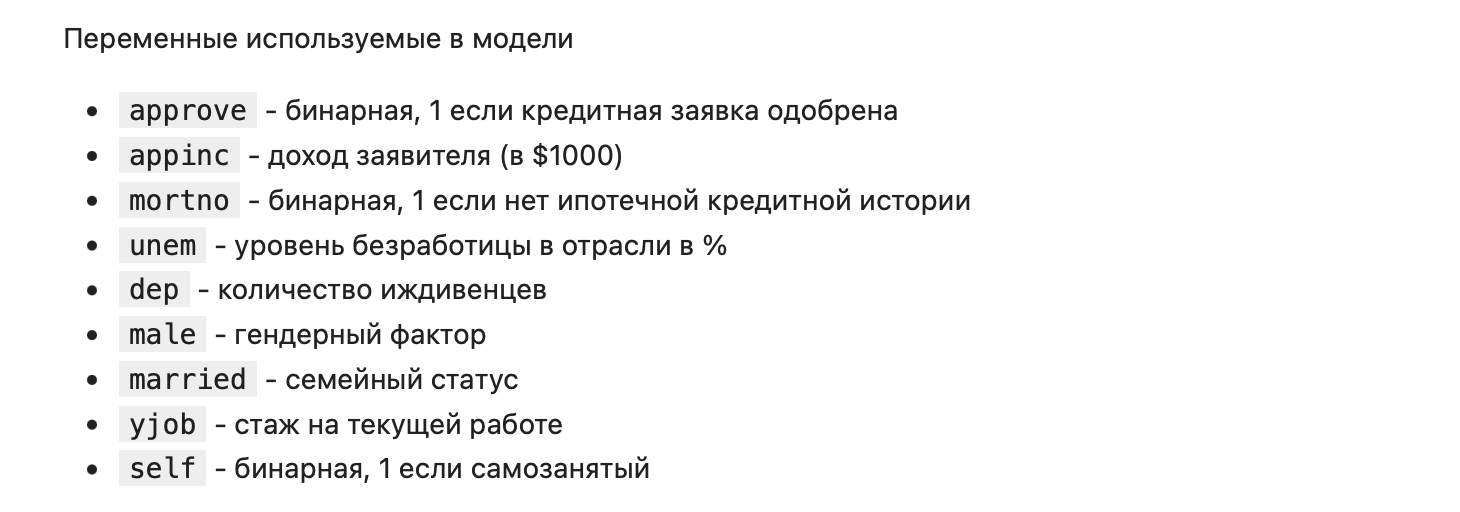

## logit-регрессия: z-тест

In [110]:
# уровень значимости 5%
# вывод результатов z-теста
summary_params(res_log)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,1.931493,0.199348,9.689062,3.355978e-22,1.540778,2.322207
appinc,-0.001002,0.000681,-1.471726,1.410949e-01,-0.002336,0.000332
mortno,0.786834,0.172123,4.571355,4.845806e-06,0.449480,1.124189
unem,-0.054946,0.029444,-1.866124,6.202401e-02,-0.112655,0.002763
dep,-0.160826,0.064690,-2.486094,1.291539e-02,-0.287617,-0.034036
male,0.029972,0.185927,0.161205,8.719318e-01,-0.334438,0.394382
married,0.424632,0.162412,2.614538,8.934816e-03,0.106311,0.742954
yjob,-0.006462,0.065061,-0.099316,9.208872e-01,-0.133979,0.121056
self,-0.280392,0.196667,-1.425719,1.539494e-01,-0.665852,0.105068


In [116]:
from scipy.stats import norm 

In [117]:
#критическое z
sign_level = 0.05
norm.ppf(q=1-sign_level/2)

1.959963984540054

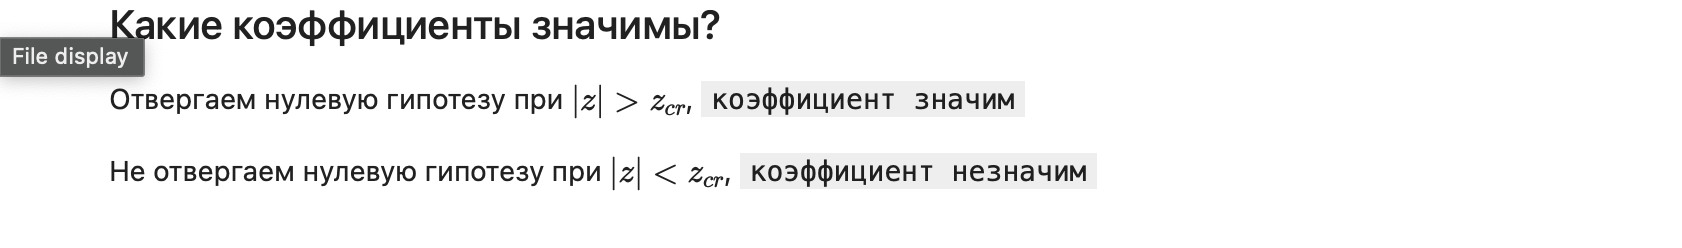

In [118]:
#если |z|>zcr коэффициент значим

In [119]:
#значимы  mortno dep married

In [120]:
# тестовые z-статистики для кажлого коэффциента с округленим
res_log.tvalues.round(3)

Intercept    9.689
appinc      -1.472
mortno       4.571
unem        -1.866
dep         -2.486
male         0.161
married      2.615
yjob        -0.099
self        -1.426
dtype: float64

In [121]:
# P-значения для z-статистик с округленим
res_log.pvalues.round(4)

Intercept    0.0000
appinc       0.1411
mortno       0.0000
unem         0.0620
dep          0.0129
male         0.8719
married      0.0089
yjob         0.9209
self         0.1539
dtype: float64

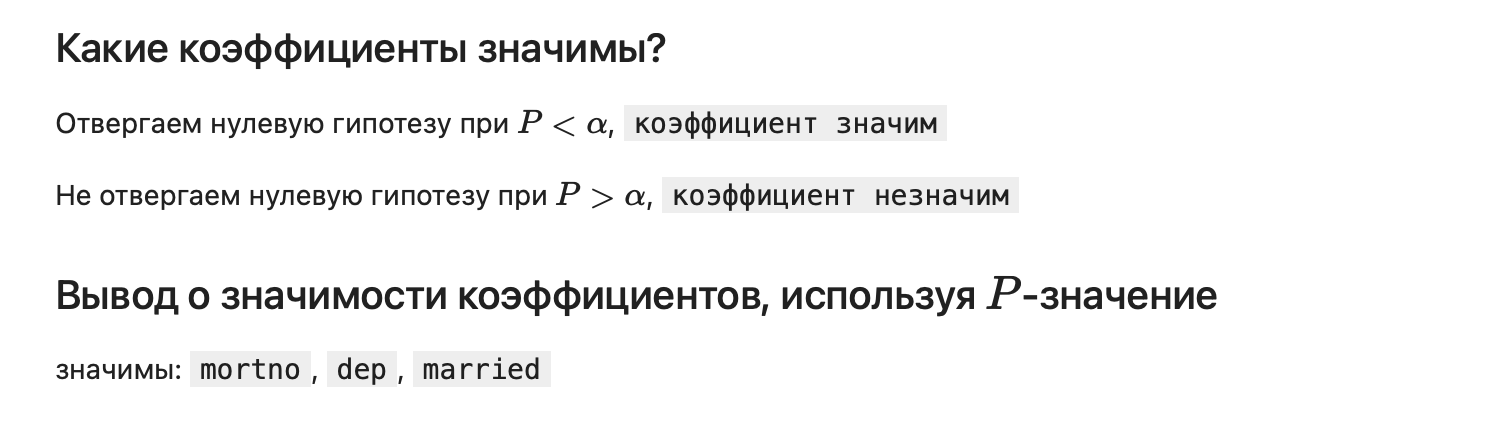

## probit-регрессия: подгонка

In [122]:
mod_prob = smf.probit(formula='approve~appinc+mortno+unem+dep+male+married+yjob+self', data=df) # спецификация модели
res_prob = mod_prob.fit() # подгонка модели

Optimization terminated successfully.
         Current function value: 0.363578
         Iterations 6


In [123]:
res_prob.summary() # отчет

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                approve   No. Observations:                 1971
Model:                         Probit   Df Residuals:                     1962
Method:                           MLE   Df Model:                            8
Date:                Mon, 01 Dec 2025   Pseudo R-squ.:                 0.02895
Time:                        02:37:43   Log-Likelihood:                -716.61
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 9.865e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1418      0.109     10.512      0.000       0.929       1.355
appinc        -0.0005      0.000     -1.375      0.169      -0.001       0.000
mortno         0.4071      0.087      4.703      0.000       0.237       0.577
unem          -0.0308      0.016     -1.909      0.056      -0.062       0.001
dep           -0.0828      0.035     -2.355      0.019      -0.152      -0.014
male           0.0200      0.099      0.201      0.841      -0.175       0.215
married        0.2208      0.086      2.552      0.011       0.051       0.390
yjob          -0.0007      0.035     -0.020      0.984      -0.069       0.068
self          -0.1583      0.107     -1.483      0.138      -0.367       0.051
==============================================================================
"""

In [125]:
# коэффициенты подогнанной модели
res_prob.params.round(3)

Intercept    1.142
appinc      -0.001
mortno       0.407
unem        -0.031
dep         -0.083
male         0.020
married      0.221
yjob        -0.001
self        -0.158
dtype: float64

**!!!! интерпретируется только знак при регрессоре**

при увеличение дохода заявителя на единицу вероятность успеха уменьшается

для людей без ипотечной кредитной истории вероятность успеха увеличивается, чем для людей с ипотечной кредитной историей

при увеличение безработицы в отрасли (unem) на единицу вероятность успеха уменьшается

при увеличение количества иждивенцев (dep) на единицу вероятность успеха уменьшается

для мужчин вероятность успеха увеличивается по отношению к женщинам

для женатых (замужних) людей вероятность успеха увеличивается по отношению к холостым

при увеличение стажа на текущей работе (yjob) на единицу вероятность успеха уменьшается

для самозанятых людей вероятность успеха уменьшается, чем для несамозанятых

## probit-регрессия: z-тест

In [126]:
# уровень значимости 10%

# вывод результатов z-теста
summary_params(res_prob)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,1.141815,0.108618,10.512194,7.590640e-26,0.928927,1.354703
appinc,-0.000528,0.000384,-1.375186,1.690737e-01,-0.001280,0.000224
mortno,0.407125,0.086575,4.702573,2.569038e-06,0.237441,0.576809
unem,-0.030792,0.016134,-1.908603,5.631333e-02,-0.062414,0.000829
dep,-0.082829,0.035177,-2.354604,1.854248e-02,-0.151775,-0.013882
male,0.019980,0.099460,0.200884,8.407890e-01,-0.174958,0.214918
married,0.220766,0.086499,2.552235,1.070342e-02,0.051231,0.390301
yjob,-0.000698,0.034866,-0.020012,9.840338e-01,-0.069034,0.067638
self,-0.158251,0.106738,-1.482615,1.381767e-01,-0.367452,0.050951


In [127]:
sign_level = 0.1
norm.ppf(q=1-sign_level/2)

1.6448536269514722

In [128]:
#отвергаем если |z|>zcr коэфф значим
#значимы motrno dep married unem

In [129]:
# тестовые z-статистики для кажлого коэффциента с округленим
res_prob.tvalues.round(3)

Intercept    10.512
appinc       -1.375
mortno        4.703
unem         -1.909
dep          -2.355
male          0.201
married       2.552
yjob         -0.020
self         -1.483
dtype: float64

In [130]:
# P-значения для z-статистик с округленим
res_prob.pvalues.round(4)

Intercept    0.0000
appinc       0.1691
mortno       0.0000
unem         0.0563
dep          0.0185
male         0.8408
married      0.0107
yjob         0.9840
self         0.1382
dtype: float64

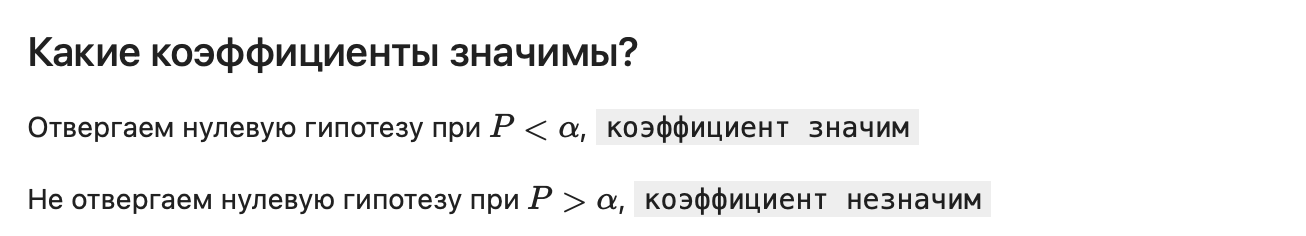

# Тема 4: Logit / Probit — значимость регрессии, совместная значимость (LR‑тест, W‑тест)

Ты хочешь понять:
Насколько модель в целом объясняет зависимую переменную (LFP, например)?
Есть ли смысл вообще использовать выбранные переменные?

Название	Что проверяет

LR‑тест (Likelihood Ratio)	Вся модель значима или нет

W‑тест (Wald test)	Совместная значимость нескольких переменных

In [132]:
#Для датасета loanapp рассморим logit-регрессию approve на appinc, appinc^2, mortno, unem, dep, male, married, yjob, self
modlr = smf.logit(formula='approve~appinc+I(appinc**2)+mortno+unem+dep+male+married+yjob+self', data=df) # спецификация модели
reslr = modlr.fit() # подгонка модели
reslr.summary() # отчет

Optimization terminated successfully.
         Current function value: 0.362116
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1961
Method:                           MLE   Df Model:                            9
Date:                Mon, 01 Dec 2025   Pseudo R-squ.:                 0.03286
Time:                        02:46:11   Log-Likelihood:                -713.73
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 2.063e-07
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.6806      0.228      7.363      0.000       1.233       2.128
appinc             0.0042      0.002      1.724      0.085      -0.001       0.009
I(appinc ** 2) -7.338e-06    3.3e-06     -2.226      0.026   -1.38e-05   -8.76e-07
mortno             0.7072      0.175      4.042      0.000       0.364       1.050
unem              -0.0498      0.030     -1.685      0.092      -0.108       0.008
dep               -0.1545      0.065     -2.371      0.018      -0.282      -0.027
male              -0.0207      0.188     -0.110      0.912      -0.388       0.347
married            0.3977      0.163      2.438      0.015       0.078       0.718
yjob              -0.0101      0.065     -0.156      0.876      -0.137       0.117
self              -0.3593      0.200     -1.801      0.072      -0.750       0.032
==================================================================================
"""

In [133]:
# Число наблюдений, по которым была оценена модель
res.nobs

1971

In [135]:
# логарифм функции правдоподобия для модели
reslr.llf.round(3)

-713.731

In [136]:
# логарфим функции правдоподобия для регрессии без объясняющих переменных (только на константу)
reslr.llnull.round(3)

-737.979

### Тестируем значимость регрессии, т.е. гипотезу
$$H_0:\\beta_{appinc}=\\beta_{appinc^2}=\\beta_{mortno}=\\beta_{unem}=\\beta_{dep}=\\beta_{male}=\\beta_{married}=\\beta_{yjob}=\\beta_{self}=0.$$

In [137]:
# Тестовая статистика LR-теста и её P-значение с округленим, значимость 5%
reslr.llr.round(3), reslr.llr_pvalue.round(3)

(48.496, 0.0)

In [138]:
# степени свободы хи кадрат
reslr.df_model

9.0

In [140]:
from scipy.stats import chi2 

In [141]:
#критическое значение хи хвадрат альфа

sign_level = 0.05 # уровень значимости
chi2.ppf(q=1-sign_level, df=reslr.df_model).round(3) 

16.919

### Значима ли регрессия?
если LRstat > хи квадрат альфа = > отвергаем нулевую гипотезу (регрессия значима)
если наоборот = незначима

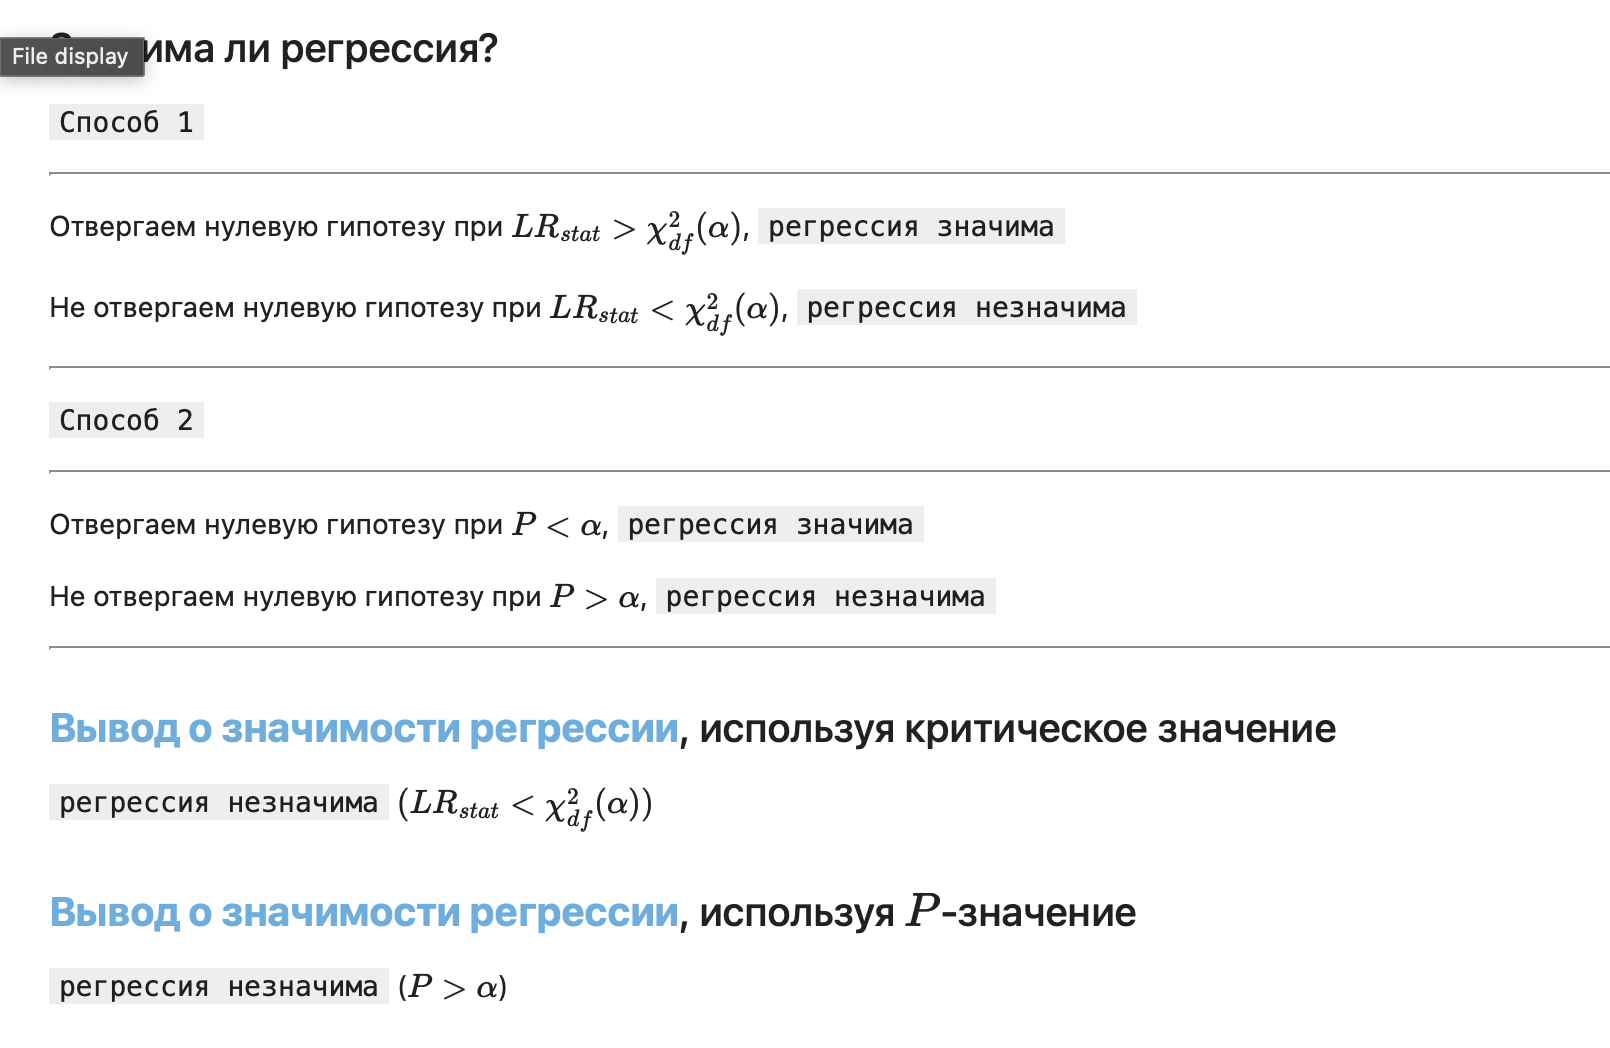

## logit-регрессия: LR-тест, совместная значимость

Тестируем значимость влияния дохода, т.е. бета апинк = бета апинк квадрат = 0

**Важно: обе регрессия д.б. оценены на одном и том же датасете!**

In [144]:
# уровень значимости 1%
# подгонка модели с ограничениями
df_modlr2 = df[['approve','appinc','mortno','unem','dep', 'male', 'married', 'yjob', 'self']].dropna()
mod_r = smf.logit(formula ='approve~mortno+unem+dep+male+married+yjob+self', data = df_modlr2)
res_r = mod_r.fit()
res_r.nobs # число наблюдений, на которых была подогнана модель

Optimization terminated successfully.
         Current function value: 0.363993
         Iterations 7


1971

In [146]:
# Тестовая статистика LR-теста с округленим
lr_stat=2*(reslr.llf-res_r.llf)
lr_stat.round(3)

7.399

In [148]:
reslr.df_model-res_r.df_model #степени свободы хи квадрат

2.0

In [149]:
# P-значение тестовой статистики LR-теста с округленим
lr_pvalue = chi2.sf(lr_stat, df=reslr.df_model-res_r.df_model)
lr_pvalue.round(3)

0.025

In [150]:
sign_level = 0.01 # уровень значимости
chi2.ppf(q=1-sign_level, df=reslr.df_model-res_r.df_model).round(3) #крит значение хи квадрат альфа

9.21

In [151]:
#вывод: влияние дохода незначимо, так как LRstat (7,399)<хи квадрат альфа (9,21)

In [152]:
# Статистика теста Вальда и её P-значение
reslr.wald_test('appinc=I(appinc ** 2)=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[7.1202905]], p-value=0.028434694253215074, df_denom=2>

### probit-регрессия: LR-тест, значимость регресии

In [153]:
modpr = smf.probit(formula='approve~appinc+unem+male+yjob+self', data=df) # спецификация модели
respr = modpr.fit() # подгонка модели
respr.summary() # отчет

Optimization terminated successfully.
         Current function value: 0.371879
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                approve   No. Observations:                 1974
Model:                         Probit   Df Residuals:                     1968
Method:                           MLE   Df Model:                            5
Date:                Mon, 01 Dec 2025   Pseudo R-squ.:                0.005805
Time:                        02:58:08   Log-Likelihood:                -734.09
converged:                       True   LL-Null:                       -738.38
Covariance Type:            nonrobust   LLR p-value:                    0.1274
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2548      0.105     11.981      0.000       1.050       1.460
appinc        -0.0004      0.000     -0.988      0.323      -0.001       0.000
unem          -0.0341      0.016     -2.139      0.032      -0.065      -0.003
male           0.1063      0.093      1.147      0.251      -0.075       0.288
yjob           0.0059      0.033      0.178      0.859      -0.059       0.071
self          -0.1255      0.105     -1.194      0.233      -0.331       0.081
==============================================================================
"""

In [154]:
# Число наблюдений, по которым была оценена модель
respr.nobs


1974

In [155]:
# логарифм функции правдоподобия для модели
respr.llf.round(3)

-734.089

In [156]:
# логарфим функции правдоподобия для регрессии без объясняющих переменных (только на константу)
respr.llnull.round(3)

-738.375

In [157]:
#ур значимости 10%

# Тестовая статистика LR-теста и её P-значение с округленим
respr.llr.round(3), respr.llr_pvalue.round(3)

(8.573, 0.127)

In [158]:
respr.df_model #хи-квадрат

5.0

In [160]:
sign_level = 0.1 # уровень значимости
chi2.ppf(q=1-sign_level, df=respr.df_model).round(3) 

9.236

In [161]:
#вывод: рергресся незначима, так как LRstat<хи квадрат альфа

## probit-регрессия: LR-тест, совместная значимость

In [166]:
# импорт датасета
df2 = pd.read_csv('TableF5-1.csv')
# импорт данных из локального файла
# df = pd.read_csv('TableF5-1.csv')
df2

,LFP,WHRS,KL6,K618,WA,WE,WW,RPWG,HHRS,HA,HE,HW,FAMINC,MTR,WMED,WFED,UN,CIT,AX
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,12,4.0288,16310,0.7215,12,7,5.0,0,14
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,9,8.4416,21800,0.6615,7,7,11.0,1,5
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,12,3.5807,21040,0.6915,12,7,5.0,0,15
3,1,456,0,3,34,12,1.0965,3.25,1920,53,10,3.5417,7300,0.7815,7,7,5.0,0,6
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,12,10.0000,27300,0.6215,12,14,9.5,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0,0,0,2,40,13,0.0000,0.00,3020,43,16,9.2715,28200,0.6215,10,10,9.5,1,5
749,0,0,2,3,31,12,0.0000,0.00,2056,33,12,4.8638,10000,0.7715,12,12,7.5,0,14
750,0,0,0,0,43,12,0.0000,0.00,2383,43,12,1.0898,9952,0.7515,10,3,7.5,0,4
751,0,0,0,0,60,12,0.0000,0.00,1705,55,8,12.4400,24984,0.6215,12,12,14.0,1,15


In [167]:
modpr2 = smf.probit(formula='LFP~WA+I(WA**2)+WE+KL6+K618+CIT+UN+np.log(FAMINC)', data=df2) # спецификация модели
respr2 = modpr2.fit() # подгонка модели
respr2.nobs # число наблюдений, на которых была подогнана модель

Optimization terminated successfully.
         Current function value: 0.613998
         Iterations 5


753

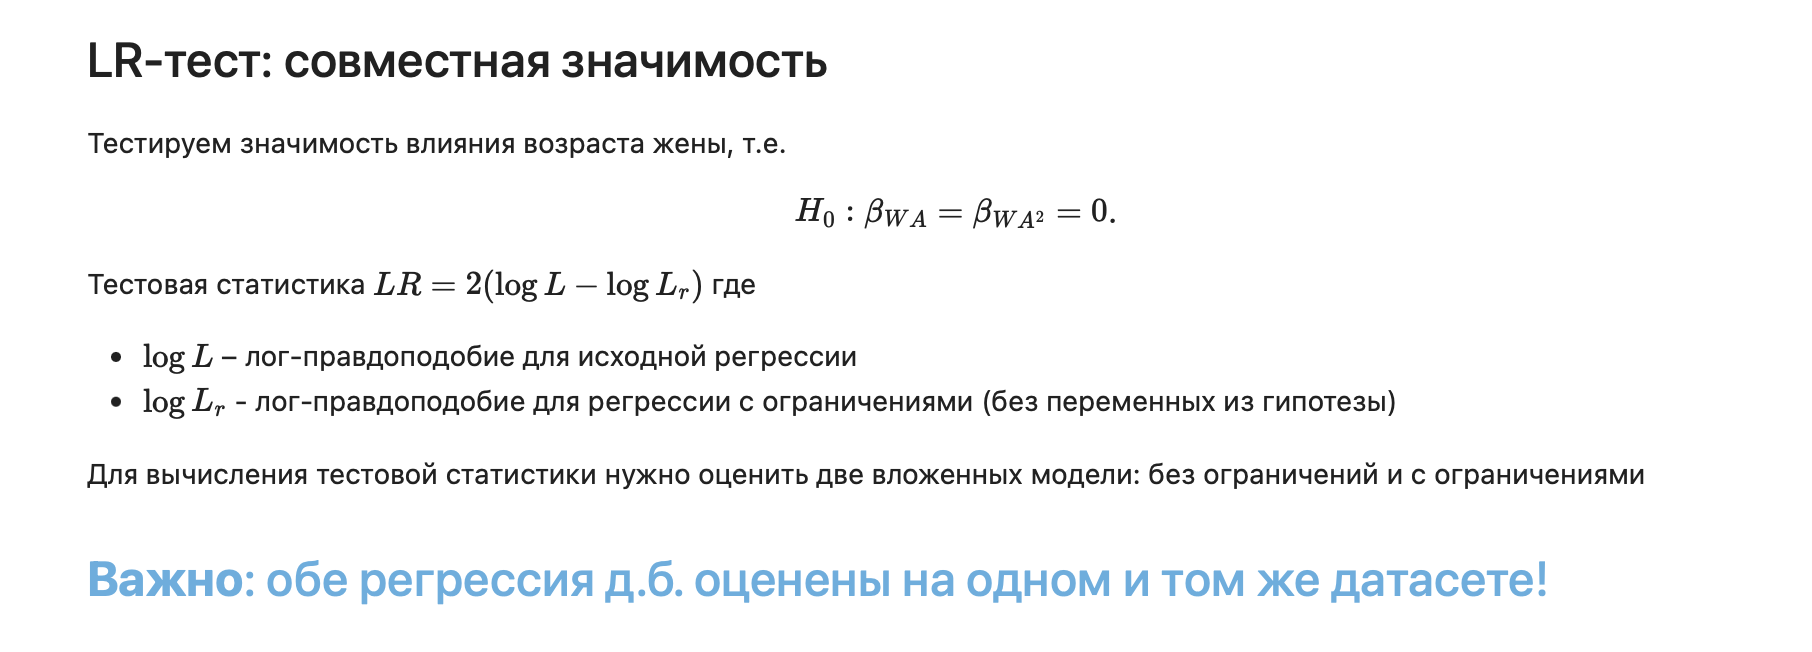

In [168]:
#alpha 10%

# подгонка модели с ограничениями
df_mod = df2[['LFP', 'WA', 'WE', 'KL6', 'K618', 'CIT', 'UN', 'FAMINC']].dropna()
mod_r2 = smf.probit(formula ='LFP~WE+KL6+K618+CIT+UN+np.log(FAMINC)', data = df_mod)
res_r2 = mod_r2.fit()
res_r2.nobs # число наблюдений, на которых была подогнана модель

Optimization terminated successfully.
         Current function value: 0.631739
         Iterations 5


753

In [170]:

# Тестовая статистика LR-теста с округленим
lr_stat2=2*(respr2.llf-res_r2.llf)
lr_stat2.round(3)

26.718

In [171]:

 respr2.df_model-res_r2.df_model #хи квадрат

2.0

In [172]:
# P-значение тестовой статистики LR-теста с округленим
lr_pvalue = chi2.sf(lr_stat, df=respr2.df_model-res_r2.df_model)
lr_pvalue.round(3)

0.0

In [173]:

sign_level = 0.1 # уровень значимости
chi2.ppf(q=1-sign_level, df=respr2.df_model-res_r2.df_model).round(3) 

4.605

In [ ]:
# LRtest (26,718)> хи квадрат альфа (4,605) поэтмоу влияние возраста жены значимо

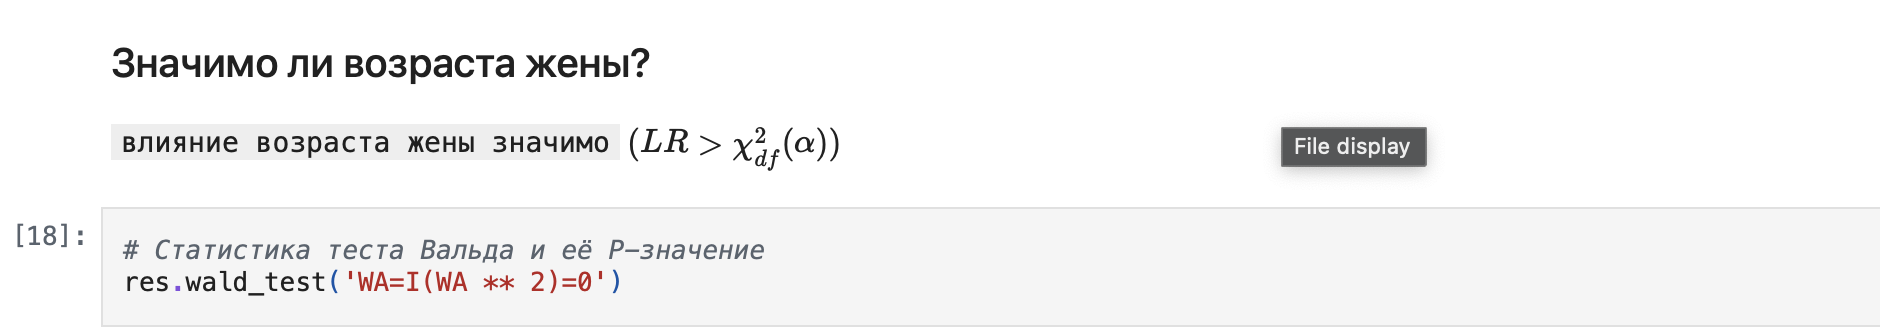

In [174]:

# Статистика теста Вальда и её P-значение
respr2.wald_test('WA=I(WA ** 2)=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[26.03018738]], p-value=2.2264688786102285e-06, df_denom=2>